In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%precision 4

cos = np.cos
sin = np.sin
twopi = np.pi*2.
pi = np.pi

def myrotate(th):
    # Add pi/2 to make it reference the x-axis
    # on range [0,pi]
    th = (th+pi/2.) if th<(3.*pi/2.) else (th-3.*pi/2.)
    if th > pi: th -= pi
    return th


In [42]:
source = "/home/walterms/mcmd/nn/data/unlbl/"
fnames = sorted([source+f for f in os.listdir(source)])
newnames = []
for f in fnames:
    if f.endswith(".log") or f.endswith("swp"): continue
    if f.startswith(source+"edge_3"): 
        newnames.append(f)
fnames = newnames

# Sort based on edge size
edges = []
for f in fnames:
    edg = float(f[len(source)+len("edge_3_"):])
    rh = 28**2 / (edg**2)
    edges.append([edg,rh])

idxs = np.argsort(edges,axis=0)
edges = np.array([edges[i] for i in idxs[:,0]])
fnames = [fnames[i] for i in idxs[:,0]]
fnames, edges = fnames[::2], edges[::2]
nfiles = len(fnames)

In [40]:
# Manually select 3 files around rho_c
f_idx = [16,19,22]
print edges[f_idx,:]
fnames = [fnames[i] for i in f_idx]
edges = edges[f_idx]

[[ 9.8     8.1633]
 [10.82    6.6967]
 [12.25    5.2245]]


In [4]:
edges[]

array([[ 7.    , 16.    ],
       [ 7.11  , 15.5088],
       [ 7.22  , 15.0398],
       [ 7.35  , 14.5125],
       [ 7.47  , 14.05  ],
       [ 7.61  , 13.5378],
       [ 7.75  , 13.0531],
       [ 7.9   , 12.5621],
       [ 8.05  , 12.0983],
       [ 8.22  , 11.6031],
       [ 8.4   , 11.1111],
       [ 8.6   , 10.6003],
       [ 8.8   , 10.124 ],
       [ 9.02  ,  9.6361],
       [ 9.26  ,  9.1431],
       [ 9.52  ,  8.6505],
       [ 9.8   ,  8.1633],
       [10.11  ,  7.6703],
       [10.45  ,  7.1793],
       [10.82  ,  6.6967],
       [11.24  ,  6.2056],
       [11.71  ,  5.7174],
       [12.25  ,  5.2245],
       [12.87  ,  4.7332],
       [13.59  ,  4.245 ]])

In [76]:
def dist_from(ref,rs):
    # ref is 1x2 ndarray
    # rs is list of vectors to compare, nx2
    return np.linalg.norm((ref-rs),axis=1)

def nematicdirector(Q):
    # Given Q matrix return order parameter and angle
    w,v = np.linalg.eig(Q)
    idx = np.argmax(w)
    Lam = w[idx] # Equiv to sqrt(S*S+T*T)
    nu = v[:,idx]
    alpha = np.angle(np.complex(nu[0,0],nu[1,0]))
    if alpha < 0: alpha = twopi+alpha
    return Lam, alpha

def Lambda(block,n_nbr,edge,use_bulk=False, rc=np.inf):
    # This only considers centers
    # Might be more effective with more precise comparisons
    # rc is a cutoff distance
    # ret_nbrs boolean as to if returning nbrs

    if use_bulk:
        block = block[np.where(block[:,0] > -0.25*edge)]
        block = block[np.where(block[:,0] < 0.25*edge)]
        block = block[np.where(block[:,1] > -0.25*edge)]
        block = block[np.where(block[:,1] < 0.25*edge)]

    block2 = block.copy()
    nrod = len(block)
    lambdas = []
    z = np.zeros((nrod,1))
    block2 = np.append(block2,z,axis=1)
    
    nem_dirs = []
    
#     # Calc S, T and global nem director
#     S = np.mean(cos(2*block[:,2]))
#     T = np.mean(sin(2*block[:,2]))
#     Q = np.matrix([[S,T],[T,-S]])
#     LAM, alpha = nematicdirector(Q)
#     print LAM
#     alpha = 0.
#     print LAM, S, T, alpha

    # From yao--This actually produces different results
#     cos_0 = 0.5*(1 + S / LAM)
#     alpha2 = np.arccos(cos_0)
        
    for i,rod in enumerate(block):
        cent = np.asarray([rod[0],rod[1]])
        dists = dist_from(cent,block2[:,:2])
        block2[:,-1] = dists
        block2 = block2[block2[:,-1].argsort()]
        
        # How many are within rc
        if rc < np.inf:
            n_nbr = len(np.where(block2[:,-1]<rc)[0]) - 1 # -1 the ref rod
#         n_nbr = min(maxnbr,n_nbr)
        
        lam = None
        
        if (1):
            # Method 3 -- From Robinson paper (also Frenkel AND Galanis)
            th_j = block2[:n_nbr,2]
            Q_11 = np.mean(2.*np.square(cos(th_j)) - 1.)
            Q_12 = np.mean(2.*cos(th_j)*sin(th_j))
            Q_22 = np.mean(2.*np.square(sin(th_j)) - 1.)
#             w,v = np.linalg.eig(np.matrix([[Q_11,Q_12],[Q_12,Q_22]]))
            lam = np.sqrt(Q_11*Q_11 + Q_12*Q_12) # This is correct expression for eigenvalue
        
        
        lambdas.append(lam)
    
    return np.array(lambdas)

In [5]:
def Lambda2(block, m, edge, nmin=5, use_bulk=False):
    # Takes block of rods, and m for m by m cells, and edge
    # coords go from [-edge/2, edge/2] for either x or y
    # nmin is the minimum number of rods for a cell
    if use_bulk:
        block = block[np.where(block[:,0] > -0.25*edge)]
        block = block[np.where(block[:,0] < 0.25*edge)]
        block = block[np.where(block[:,1] > -0.25*edge)]
        block = block[np.where(block[:,1] < 0.25*edge)]

    edge *= 0.5
    
    nrod = len(block)
    delm = 1./m
    lambdas = np.zeros(shape=(m,m),dtype=float)
    block2 = block.copy()
    block2[:,0] = block2[:,0] / edge + 0.5
    block2[:,1] = block2[:,1] / edge + 0.5
    xcells = np.floor(block2[:,0] / delm)
    ycells = np.floor(block2[:,1] / delm)
    block2 = np.append(block2,xcells.reshape(nrod,1),axis=1)
    block2 = np.append(block2,ycells.reshape(nrod,1),axis=1)

    for xc in range(m):
        if ignore_walls:
            if xc == 0 or xc == m-1: continue
        for yc in range(m):
            if ignore_walls:
                if yc == 0 or yc == m-1: continue
            thetas = []
            for rod in block2:
                if (rod[3] == float(xc)) and (rod[4] == float(yc)):
                    thetas.append(rod[2])
                    
            if len(thetas) < nmin: continue
            S = np.mean(cos(2.* np.array(thetas)))
            T = np.mean(sin(2.* np.array(thetas)))
            lambdas[xc,yc] = np.sqrt(S*S+T*T)

    return lambdas.flatten()

In [17]:
def Lambda_bulk_global(block, edge):
    block = block[np.where(block[:,0] > -0.25*edge)]
    block = block[np.where(block[:,0] < 0.25*edge)]
    block = block[np.where(block[:,1] > -0.25*edge)]
    block = block[np.where(block[:,1] < 0.25*edge)]

    block2 = block.copy()
    nrod = len(block)
#     z = np.zeros((nrod,1))
#     block2 = np.append(block2,z,axis=1)

    # Calc S, T and global nem director
    S = np.mean(cos(2*block[:,2]))
    T = np.mean(sin(2*block[:,2]))
    Q = np.matrix([[S,T],[T,-S]])
    Lam, alpha = nematicdirector(Q)
    
    return Lam

In [77]:
# This block is different
# It's for handling the FNN unlabeled dataset
NBL = 10
n_nbr=0
nrod = 28**2
RC = np.linspace(1.,10.,30)
m = 5
nmin = 5
use_bulk=True
nblskip = 2
# nlambda = 784*NBL // 2
# nlambda = NBL*m*m
nlambda = NBL*nrod // 4

lambdas = np.empty((nfiles,len(RC),nlambda))


for ifile,f in enumerate(fnames):
    fin = open(f,'r')
    params = {}
    params.update({"ReducedRho": edges[ifile,1]})
    params.update({"boxEdge": edges[ifile,0]})
    print f,params["ReducedRho"]
    edge = params["boxEdge"]
    nbl = 0
    lambdacount = 0
    rods = np.zeros((nrod,3))
    cells = np.zeros((nrod,1))
    irod = 0
    
    for line in fin.readlines():
        if nbl < nblskip:
            if line == "\n": nbl+=1
            continue
        if line == "\n":
            # Done a block
            #
            # Calculate avg lambda for each rc
            # We will use a weighted average method:
            # Store <lambda> and number of lambdas used etc....
            
            for i_nb,rc in enumerate(RC):
                L = Lambda(rods,n_nbr,edge,use_bulk=use_bulk,rc=rc)
                if len(L) + lambdacount >= nlambda:
                    L = L[:nlambda-lambdacount]
                lambdas[ifile,i_nb,lambdacount:(lambdacount+len(L))] = L

            # Each lambdacount will be the same for each n_nbr
            lambdacount += len(L)
            if lambdacount >= nlambda:
                break
            nbl+=1
            rods = np.zeros((nrod,3))
            cells = np.zeros((nrod,1))
            irod = 0
            continue

        rod = [float(s) for s in line.split()]
        rod[0] *= edge
        rod[1] *= edge
        rod[2] *= twopi
        rods[irod] = rod
        irod+=1
    fin.close()
#   print np.mean(lambdas[ifile])
#     _=plt.plot(lambdas[ifile],'k.',markersize=2)
#     _=plt.axis([0,nlambda,-1,1])
#     plt.show()

# lvar = np.var(lambdas,axis=1)
# _ = plt.plot(edges[:,1],lvar,'o')
# _ = plt.xlabel(r'$\rho$')
# _ = plt.ylabel(r'$\sigma^2(\lambda)$',rotation="horizontal",labelpad=20)
# plt.show()

print "Done"

/home/walterms/mcmd/nn/data/unlbl/edge_3_7.00 16.0
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.11 15.50875235647975
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.22 15.039786373646612
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.35 14.5124716553288
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.47 14.049952599330835
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.61 13.537758085097932
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.75 13.053069719042664
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.90 12.562089408748598
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.05 12.09829867674858
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.22 11.603057050337139
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.40 11.11111111111111
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.60 10.600324499729584
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.80 10.123966942148758
/home/walterms/mcmd/nn/data/unlbl/edge_3_9.02 9.636137482116608
/home/walterms/mcmd/nn/data/unlbl/edge_3_9.26 9.143113043397134
/home/walterms/mcmd/nn/data/unlbl/edge_3_9.52 

In [43]:
# This block is different
# It's for handling the FNN unlabeled dataset
NBL = 10
nrod = 28**2
N_NBRS = np.arange(1,31)
m = 5
nmin = 5
use_bulk=True
nblskip = 2
# nlambda = 784*NBL // 2
# nlambda = NBL*m*m
nlambda = NBL*nrod // 4

lambdas = np.empty((nfiles,len(N_NBRS),nlambda))


for ifile,f in enumerate(fnames):
    fin = open(f,'r')
    params = {}
    params.update({"ReducedRho": edges[ifile,1]})
    params.update({"boxEdge": edges[ifile,0]})
    print f,params["ReducedRho"]
    edge = params["boxEdge"]
    nbl = 0
    lambdacount = 0
    rods = np.zeros((nrod,3))
    cells = np.zeros((nrod,1))
    irod = 0
    
    for line in fin.readlines():
        if nbl < nblskip:
            if line == "\n": nbl+=1
            continue
        if line == "\n":
            # Done a block
            #
            # Calculate avg lambda for each n_nbr
            # We will use a weighted average method:
            # Store <lambda> and number of lambdas used etc....
            
            for i_nb,n_nbr in enumerate(N_NBRS):
                L = Lambda(rods,n_nbr,edge,use_bulk=use_bulk)
                if len(L) + lambdacount >= nlambda:
                    L = L[:nlambda-lambdacount]
                lambdas[ifile,i_nb,lambdacount:(lambdacount+len(L))] = L

            # Each lambdacount will be the same for each n_nbr
            lambdacount += len(L)
            if lambdacount >= nlambda:
                break
            nbl+=1
            rods = np.zeros((nrod,3))
            cells = np.zeros((nrod,1))
            irod = 0
            continue

        rod = [float(s) for s in line.split()]
        rod[0] *= edge
        rod[1] *= edge
        rod[2] *= twopi
        rods[irod] = rod
        irod+=1
    fin.close()
#   print np.mean(lambdas[ifile])
#     _=plt.plot(lambdas[ifile],'k.',markersize=2)
#     _=plt.axis([0,nlambda,-1,1])
#     plt.show()

# lvar = np.var(lambdas,axis=1)
# _ = plt.plot(edges[:,1],lvar,'o')
# _ = plt.xlabel(r'$\rho$')
# _ = plt.ylabel(r'$\sigma^2(\lambda)$',rotation="horizontal",labelpad=20)
# plt.show()

print "Done"

/home/walterms/mcmd/nn/data/unlbl/edge_3_7.00 16.0
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.11 15.50875235647975
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.22 15.039786373646612
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.35 14.5124716553288
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.47 14.049952599330835
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.61 13.537758085097932
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.75 13.053069719042664
/home/walterms/mcmd/nn/data/unlbl/edge_3_7.90 12.562089408748598
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.05 12.09829867674858
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.22 11.603057050337139
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.40 11.11111111111111
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.60 10.600324499729584
/home/walterms/mcmd/nn/data/unlbl/edge_3_8.80 10.123966942148758
/home/walterms/mcmd/nn/data/unlbl/edge_3_9.02 9.636137482116608
/home/walterms/mcmd/nn/data/unlbl/edge_3_9.26 9.143113043397134
/home/walterms/mcmd/nn/data/unlbl/edge_3_9.52 

In [78]:
lambdameans = np.mean(lambdas,axis=2)
lambdavars = np.var(lambdas, axis=2)

In [79]:
lambdameans.shape

(25, 30)

In [81]:
for fi, edg in enumerate(edges[:,0]):
    fout = open("/home/walterms/mcmd/nn/data/correlation_data_rc/corr_len_edge_3_"+str(edg)+".dat",'w')
    for i,rc in enumerate(RC):
        fout.write("%g %g %g\n"%(rc,lambdameans[fi,i],lambdavars[fi,i]))
    fout.close()

In [87]:
edges

array([[ 7.    , 16.    ],
       [ 7.11  , 15.5088],
       [ 7.22  , 15.0398],
       [ 7.35  , 14.5125],
       [ 7.47  , 14.05  ],
       [ 7.61  , 13.5378],
       [ 7.75  , 13.0531],
       [ 7.9   , 12.5621],
       [ 8.05  , 12.0983],
       [ 8.22  , 11.6031],
       [ 8.4   , 11.1111],
       [ 8.6   , 10.6003],
       [ 8.8   , 10.124 ],
       [ 9.02  ,  9.6361],
       [ 9.26  ,  9.1431],
       [ 9.52  ,  8.6505],
       [ 9.8   ,  8.1633],
       [10.11  ,  7.6703],
       [10.45  ,  7.1793],
       [10.82  ,  6.6967],
       [11.24  ,  6.2056],
       [11.71  ,  5.7174],
       [12.25  ,  5.2245],
       [12.87  ,  4.7332],
       [13.59  ,  4.245 ]])

From red -> blue is nem -> iso
The more isotropic a state, the more sensitive to rc


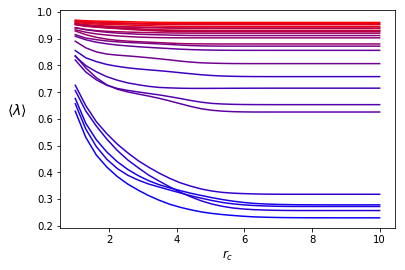

In [92]:
print "From red -> blue is nem -> iso"
print "The more isotropic a state, the more sensitive to rc"

f,ax = plt.subplots(1,1)
for i in range(nfiles):
    _ = ax.plot(RC,lambdameans[i],color=(1-float(i)/nfiles, 0, float(i)/nfiles),linestyle='-')
    
_=ax.set_xlabel(r'$r_c$',fontsize=12)
_=ax.set_ylabel(r'$\langle\lambda\rangle$',rotation="horizontal",labelpad=20,fontsize=14)

From red -> blue is nem -> iso
The more isotropic a state, the more sensitive to rc


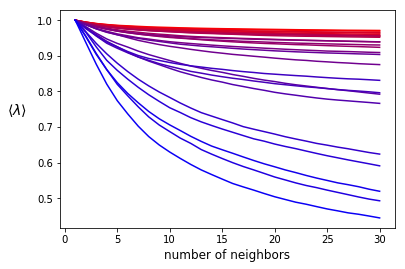

In [68]:
print "From red -> blue is nem -> iso"
print "The more isotropic a state, the more sensitive to rc"

f,ax = plt.subplots(1,1)
for i in range(nfiles):
    _ = ax.plot(N_NBRS,lambdameans[i],color=(1-float(i)/nfiles, 0, float(i)/nfiles),linestyle='-')
    
_=ax.set_xlabel("number of neighbors",fontsize=12)
_=ax.set_ylabel(r'$\langle\lambda\rangle$',rotation="horizontal",labelpad=20,fontsize=14)

In [86]:
f.savefig("/home/walterms/mcmd/imgs/paperimgs/correlation_lengths.png")

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

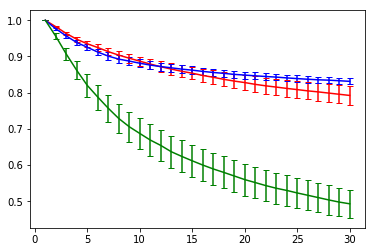

In [37]:
plt.errorbar(N_NBRS,lambdameans[0],yerr=lambdavars[0],fmt='r',capsize=3)
plt.errorbar(N_NBRS,lambdameans[1],yerr=lambdavars[1],fmt='b',capsize=3)
plt.errorbar(N_NBRS,lambdameans[2],yerr=lambdavars[2],fmt='g',capsize=3)


In [ ]:
f,ax = plt.subplots(1,1)
plt.plot(edges[:,1],var_bulk,"+",edges[:,1],var_glob,"o")

In [ ]:
f.savefig("/home/walterms/mcmd/imgs/paperimgs/bulk-global-compare.eps")